## Text identification using OpenCV, Tesseract (OCR) and deep neural network 

In [2]:
# !pip install opencv-python pytesseract imutils matplotlib

In [25]:
import cv2
import numpy as np
import pytesseract

# Load the image
image = cv2.imread('image.png')
orig = image.copy()
(H, W) = image.shape[:2]


(-0.5, 682.5, 674.5, -0.5)

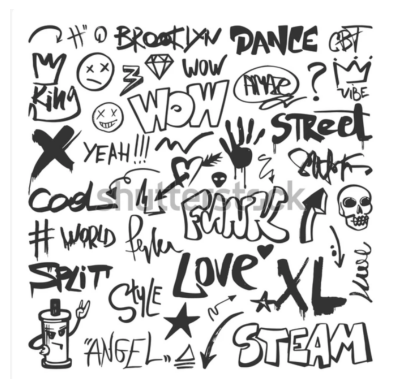

In [26]:
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

In [27]:
net = cv2.dnn.readNet("frozen_east_text_detection.pb")

# Set the new width and height (must be multiple of 32)
(newW, newH) = (320, 320)
rW = W / float(newW)
rH = H / float(newH)

resized = cv2.resize(image, (newW, newH))
blob = cv2.dnn.blobFromImage(resized, 1.0, (newW, newH),
                             (123.68, 116.78, 103.94), swapRB=True, crop=False)
net.setInput(blob)

# Define output layers
layerNames = [
    "feature_fusion/Conv_7/Sigmoid",
    "feature_fusion/concat_3"
]

(scores, geometry) = net.forward(layerNames)


In [28]:
def decode_predictions(scores, geometry, min_confidence=0.5):
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    for y in range(numRows):
        scoresData = scores[0,0,y]
        xData0 = geometry[0,0,y]
        xData1 = geometry[0,1,y]
        xData2 = geometry[0,2,y]
        xData3 = geometry[0,3,y]
        anglesData = geometry[0,4,y]

        for x in range(numCols):
            if scoresData[x] < min_confidence:
                continue

            offsetX = x * 4.0
            offsetY = y * 4.0

            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            rects.append((startX, startY, endX, endY))
            confidences.append(float(scoresData[x]))

    return (rects, confidences)

rects, confidences = decode_predictions(scores, geometry)

# Apply non-maxima suppression
from imutils.object_detection import non_max_suppression
boxes = non_max_suppression(np.array(rects), probs=confidences)


In [29]:
results = []

for (startX, startY, endX, endY) in boxes:
    # Scale coordinates back to original image
    startX = int(startX * rW)
    startY = int(startY * rH)
    endX = int(endX * rW)
    endY = int(endY * rH)

    # Extract the ROI and apply OCR
    roi = orig[startY:endY, startX:endX]
    config = ("-l eng --oem 1 --psm 7")
    text = pytesseract.image_to_string(roi, config=config)
    results.append(((startX, startY, endX, endY), text))

    # Draw bounding box and text on image
    cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)
    cv2.putText(orig, text.strip(), (startX, startY - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

cv2.imshow("Text Detection", orig)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [8]:
from datasets import load_dataset

ds = load_dataset("MiXaiLL76/ICDAR2015_OCR")
ds

README.md: 0.00B [00:00, ?B/s]

c:\Users\shubh\Downloads\AI ML\venv\lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\shubh\.cache\huggingface\hub\datasets--MiXaiLL76--ICDAR2015_OCR. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


train-00000-of-00001.parquet:   0%|          | 0.00/29.1M [00:00<?, ?B/s]

train_numbers-00000-of-00001.parquet:   0%|          | 0.00/321k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/15.3M [00:00<?, ?B/s]

test_numbers-00000-of-00001.parquet:   0%|          | 0.00/53.6k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4468 [00:00<?, ? examples/s]

Generating train_numbers split:   0%|          | 0/111 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2077 [00:00<?, ? examples/s]

Generating test_numbers split:   0%|          | 0/20 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 4468
    })
    train_numbers: Dataset({
        features: ['image', 'text'],
        num_rows: 111
    })
    test: Dataset({
        features: ['image', 'text'],
        num_rows: 2077
    })
    test_numbers: Dataset({
        features: ['image', 'text'],
        num_rows: 20
    })
})

In [9]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 4468
    })
    train_numbers: Dataset({
        features: ['image', 'text'],
        num_rows: 111
    })
    test: Dataset({
        features: ['image', 'text'],
        num_rows: 2077
    })
    test_numbers: Dataset({
        features: ['image', 'text'],
        num_rows: 20
    })
})

In [14]:
# !pip install evaluate
# !pip install jiwer


In [23]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 4468
    })
    train_numbers: Dataset({
        features: ['image', 'text'],
        num_rows: 111
    })
    test: Dataset({
        features: ['image', 'text'],
        num_rows: 2077
    })
    test_numbers: Dataset({
        features: ['image', 'text'],
        num_rows: 20
    })
})

In [24]:
sample = ds["test"][0]
print(sample["image"])   # a PIL image
print(sample["text"])    # e.g., "JOINT"


<PIL.PngImagePlugin.PngImageFile image mode=RGB size=113x33 at 0x18D5FBAA0B0>
JOINT


In [16]:
print(ds["test"])

Dataset({
    features: ['image', 'text'],
    num_rows: 2077
})


In [20]:
from tqdm import tqdm
import numpy as np
import cv2
import pytesseract
from jiwer import wer, cer

ground_truths = []
predictions = []

for i in tqdm(range(50)):  # first 50 samples
    sample = ds["test"][i]   # dict
    pil_img = sample["image"]  # PIL Image
    img = np.array(pil_img)    # convert to numpy

    # Convert RGB → BGR for OpenCV
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    orig = img.copy()
    (H, W) = img.shape[:2]

    # EAST preprocessing
    resized = cv2.resize(img, (320, 320))
    blob = cv2.dnn.blobFromImage(resized, 1.0, (320, 320),
                                 (123.68, 116.78, 103.94),
                                 swapRB=True, crop=False)
    net.setInput(blob)
    (scores, geometry) = net.forward(layerNames)
    rects, confidences = decode_predictions(scores, geometry)
    boxes = non_max_suppression(np.array(rects), probs=confidences)

    text_result = []
    for (startX, startY, endX, endY) in boxes:
        startX = int(startX * (W / 320))
        startY = int(startY * (H / 320))
        endX = int(endX * (W / 320))
        endY = int(endY * (H / 320))

        roi = orig[startY:endY, startX:endX]
        config = ("-l eng --oem 1 --psm 7")
        text = pytesseract.image_to_string(roi, config=config).strip()
        if text:
            text_result.append(text)

    pred_text = " ".join(text_result)
    predictions.append(pred_text)
    ground_truths.append(sample["text"])

print("WER:", wer(ground_truths, predictions))
print("CER:", cer(ground_truths, predictions))


100%|██████████| 50/50 [00:05<00:00,  9.07it/s]

WER: 1.0
CER: 1.0


In [21]:
from tqdm import tqdm
import numpy as np
import cv2
import pytesseract
from jiwer import wer, cer

ground_truths = []
predictions = []

for i in tqdm(range(50)):  # first 50 samples
    sample = ds["test"][i]
    pil_img = sample["image"]  # PIL Image
    img = np.array(pil_img)

    # Convert RGB → BGR for OpenCV
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    orig = img.copy()
    (H, W) = img.shape[:2]

    # EAST preprocessing
    resized = cv2.resize(img, (320, 320))
    blob = cv2.dnn.blobFromImage(resized, 1.0, (320, 320),
                                 (123.68, 116.78, 103.94),
                                 swapRB=True, crop=False)
    net.setInput(blob)
    (scores, geometry) = net.forward(layerNames)
    rects, confidences = decode_predictions(scores, geometry, min_confidence=0.7)
    boxes = non_max_suppression(np.array(rects), probs=confidences)

    text_result = []
    for (startX, startY, endX, endY) in boxes:
        startX = int(startX * (W / 320))
        startY = int(startY * (H / 320))
        endX = int(endX * (W / 320))
        endY = int(endY * (H / 320))

        roi = orig[startY:endY, startX:endX]
        config = "-l eng --oem 1 --psm 6"   # more flexible than psm 7
        text = pytesseract.image_to_string(roi, config=config).strip()
        if text:
            text_result.append(text)

    pred_text = " ".join(text_result)
    predictions.append(pred_text)
    ground_truths.append(sample["text"])

    # Debug print for first 5 samples
    if i < 5:
        print(f"Sample {i+1}")
        print("GT   :", sample["text"])
        print("PRED :", pred_text if pred_text else "<<<EMPTY>>>")
        print("-" * 40)

print("WER:", wer(ground_truths, predictions))
print("CER:", cer(ground_truths, predictions))


  4%|▍         | 2/50 [00:00<00:05,  8.80it/s]

Sample 1
GT   : JOINT
PRED : <<<EMPTY>>>
----------------------------------------
Sample 2
GT   : yourself
PRED : <<<EMPTY>>>
----------------------------------------
Sample 3
GT   : 154
PRED : <<<EMPTY>>>
----------------------------------------


 10%|█         | 5/50 [00:00<00:05,  8.69it/s]

Sample 4
GT   : 197
PRED : <<<EMPTY>>>
----------------------------------------
Sample 5
GT   : 727
PRED : <<<EMPTY>>>
----------------------------------------


100%|██████████| 50/50 [00:05<00:00,  9.24it/s]

WER: 1.0
CER: 1.0


In [22]:
import matplotlib.pyplot as plt

if i < 3:  # show first 3 samples
    vis = orig.copy()
    for (x1, y1, x2, y2) in boxes:
        cv2.rectangle(vis, (x1, y1), (x2, y2), (0,255,0), 2)
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.title(f"GT: {sample['text']}")
    plt.show()
